<a href="https://colab.research.google.com/github/Aisthetic/Aisthetic/blob/main/simple_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading depencies

In [ ]:
!pip install traffic livelossplot ray &> /dev/null
# Restart runtime to import newer versions of libs
import os
os.kill(os.getpid(), 9)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
colab_root = '/content/drive/MyDrive/Github/Autoencoders'
%cd /content/drive/MyDrive/Github/Autoencoders

Mounted at /content/drive
/content/drive/MyDrive/Github/Autoencoders


In [ ]:
from sklearn.cluster import DBSCAN

import os
import gc

import numpy as np
import pandas as pd

import torch
from torch import nn, optim

from tqdm.autonotebook import tqdm
from tqdm import trange

from livelossplot import PlotLosses

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

from sklearn.cluster import DBSCAN
from sklearn import metrics, preprocessing 
from sklearn.preprocessing import StandardScaler
import sklearn

import matplotlib.pyplot as plt 

from models.autoencoder import Autoencoder

In [ ]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

# Data preparation
## From "Deep Trajectory Clustering with Autoencoders" (Olive et al.)
Trajectories are downsampled with a rate of 64 points per trajectory and four features per trajectory point have been selected for clustering: true track angle (unwrapped), longitude, latitude and altitude. We focused on two specific subsets of trajectories: all trajectories landing on runway 14 (14,441 trajectories) and a focus on the subset of trajectories coming from a northbound flow (initial bearing between 162 and 216°, 4437 trajectories)

In [ ]:
from traffic.data.datasets import landing_zurich_2019
initial_dataset = landing_zurich_2019.query("runway == '14' and initial_flow != 'N/A'").query("initial_flow == '162-216'").resample(64).unwrap("track").eval()

Output()

/usr/local/lib/python3.8/dist-packages/traffic/data/datasets/__init__.py:80: TqdmExperimentalWarning: rich is experimental/alpha
  for chunk in tqdm(


In [ ]:
initial_dataset.data

,timestamp,altitude,callsign,geoaltitude,groundspeed,icao24,lastseen,latitude,longitude,onground,origin,track,vertical_rate,distance,flight_id,runway,initial_bearing,initial_flow,simple,track_unwrapped
0,2019-10-31 08:45:10+00:00,13775.0,ABP721,14125.0,357.358055,49d044,2019-10-31 09:02:19+00:00,48.118069,8.727722,False,LKPR,219.436058,-1088.0,39.883791,ABP721_5357,14,190.573220,162-216,True,219.436058
1,2019-10-31 08:45:25+00:00,13525.0,ABP721,13875.0,355.686353,49d044,2019-10-31 09:02:19+00:00,48.098796,8.703918,False,LKPR,219.867446,-1088.0,38.578643,ABP721_5357,14,190.573220,162-216,True,219.867446
2,2019-10-31 08:45:40+00:00,13250.0,ABP721,13625.0,355.444485,49d044,2019-10-31 09:02:19+00:00,48.080222,8.680467,False,LKPR,220.321549,-1024.0,37.332005,ABP721_5357,14,190.573220,162-216,True,220.321549
3,2019-10-31 08:45:55+00:00,13000.0,ABP721,13350.0,354.684060,49d044,2019-10-31 09:02:19+00:00,48.061415,8.657227,False,LKPR,219.266625,-1088.0,36.088789,ABP721_5357,14,190.573220,162-216,True,219.266625
4,2019-10-31 08:46:10+00:00,12725.0,ABP721,13075.0,354.919403,49d044,2019-10-31 09:02:19+00:00,48.042328,8.633775,False,LKPR,219.846985,-1024.0,34.845588,ABP721_5357,14,190.573220,162-216,True,219.846985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2019-11-17 11:42:53+00:00,2225.0,YUPMK,2125.0,123.109601,4c3d8a,2019-11-17 11:46:23+00:00,47.500647,8.510672,False,UUEE,136.974934,-640.0,2.665578,YUPMK_19068,14,189.699732,162-216,True,136.974934
60,2019-11-17 11:43:04+00:00,2125.0,YUPMK,2000.0,120.341078,4c3d8a,2019-11-17 11:46:23+00:00,47.496131,8.516869,False,UUEE,137.371842,-640.0,2.298496,YUPMK_19068,14,189.699732,162-216,True,137.371842
61,2019-11-17 11:43:14+00:00,2000.0,YUPMK,1850.0,120.282896,4c3d8a,2019-11-17 11:46:23+00:00,47.492157,8.522232,False,UUEE,137.021365,-640.0,1.978455,YUPMK_19068,14,189.699732,162-216,True,137.021365
62,2019-11-17 11:43:25+00:00,1875.0,YUPMK,1775.0,120.282896,4c3d8a,2019-11-17 11:46:23+00:00,47.487658,8.528419,False,UUEE,137.021365,-704.0,1.615259,YUPMK_19068,14,189.699732,162-216,True,137.021365


In [ ]:
initial_dataset.data[initial_dataset.data.flight_id == "ABP721_5357"].shape

(64, 20)

Turning timestamp into an integer

In [ ]:
list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
data = initial_dataset.data[["flight_id"] + list_features]

data

,flight_id,track_unwrapped,longitude,latitude,altitude
0,ABP721_5357,219.436058,8.727722,48.118069,13775.0
1,ABP721_5357,219.867446,8.703918,48.098796,13525.0
2,ABP721_5357,220.321549,8.680467,48.080222,13250.0
3,ABP721_5357,219.266625,8.657227,48.061415,13000.0
4,ABP721_5357,219.846985,8.633775,48.042328,12725.0
...,...,...,...,...,...
59,YUPMK_19068,136.974934,8.510672,47.500647,2225.0
60,YUPMK_19068,137.371842,8.516869,47.496131,2125.0
61,YUPMK_19068,137.021365,8.522232,47.492157,2000.0
62,YUPMK_19068,137.021365,8.528419,47.487658,1875.0


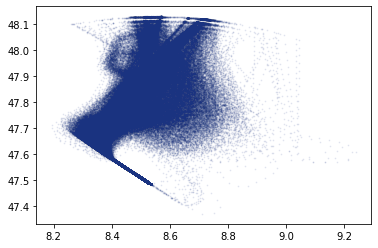

In [ ]:
import matplotlib.pyplot as plt 

plt.scatter(x=initial_dataset.data["longitude"], y=initial_dataset.data["latitude"], s=0.5, color=(0.1, 0.2, 0.5, 0.1))

Grouping up trajectories by their flight_id

In [ ]:
data_grouped = data.groupby('flight_id').apply(lambda x: x.drop("flight_id", axis=1).to_numpy()).reset_index(name="trajectories")
data_grouped

,flight_id,trajectories
0,ABP721_5357,"[[219.43605846854442, 8.72772216796875, 48.118..."
1,ACA802_20938,"[[184.39870535499549, 8.544960021972656, 48.12..."
2,AFL2390_3050,"[[208.495638618245, 8.70941162109375, 48.12016..."
3,AFL2390_3060,"[[215.74245097125268, 8.707832336425781, 48.12..."
4,AFL2390_3081,"[[216.10109727259103, 8.706312913161057, 48.12..."
...,...,...
4432,WGT8H_1477,"[[182.98146121998218, 8.526901245117188, 48.12..."
4433,WGT8H_1478,"[[168.3521856327033, 8.572700500488281, 48.128..."
4434,XRO529_4800,"[[190.6697828044967, 8.566177368164062, 48.128..."
4435,XRO652_4792,"[[191.9814747080119, 8.568923950195312, 48.128..."


Creating the pytorch dataset and dataloader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Converting to numpy arrays
flight_ids = data_grouped["flight_id"].values.tolist()
trajectories = torch.tensor(data_grouped["trajectories"].values.tolist())

# Enconding trajectories
le = preprocessing.LabelEncoder().fit(flight_ids)
encoded_fid = torch.tensor(le.transform(flight_ids))

# Creating a dataset
dataset = TensorDataset(encoded_fid, trajectories) # create your datset

# Setting the batch size
batch_size = len(dataset)
# batch_size = 1000

dataloader_train = DataLoader(dataset, batch_size=batch_size, shuffle=False) # data loader for training
dataloader_score = DataLoader(dataset, batch_size=1, shuffle=False) # data loader for scoring

<ipython-input-10-df21439bff95>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  trajectories = torch.tensor(data_grouped["trajectories"].values.tolist())


In [ ]:
for flight_id, trajectory in dataloader_score: 
    print()
    print(trajectory[0].shape)
    break


torch.Size([64, 4])


# Defining model functions

In [ ]:

def train_ae(config, epochs=500,return_model=False, log_loss = False, plot_loss = False) : 
  # Instantiate the model 
  model = Autoencoder()
  # Validation using MSE Loss function
  loss_function = torch.nn.MSELoss()
  
  # Using an Adam Optimizer
  optimizer = torch.optim.Adam(model.parameters(),
                              lr = config["lr"],
                              weight_decay = 0) 
  outputs = []
  losses = []

  model.train()
  liveloss = PlotLosses()

  # Only enable trange for logging 
  if log_loss : 
    epochs_range = trange(epochs)
  else : 
    epochs_range = tqdm(range(epochs))

  epoch_loss = 0
  for epoch in epochs_range:
      logs = {}
      epoch_loss = 0
      i = 0 
      for flight_id, trajectory in dataloader_train:
        reshaped_trajectory = trajectory.reshape(-1, 4*64)
        scaled_trajectory =  torch.Tensor(sklearn.preprocessing.minmax_scale(reshaped_trajectory, feature_range=(0, 1)))

        # Output of Autoencoder
        reconstructed = model(scaled_trajectory)

        # Calculating the loss function
        loss = loss_function(reconstructed, scaled_trajectory)
        
        # Zero out all of the gradients for the variables which the optimizer
        # will update.
        optimizer.zero_grad()

        # This is the backwards pass: compute the gradient of the loss with
        # respect to each  parameter of the model.
        loss.backward()

        # Actually update the parameters of the model using the gradients
        # computed by the backwards pass.
        optimizer.step()
        
        # Storing the losses in a list for plotting
        epoch_loss += loss.item()
        losses.append(loss.cpu().detach())

      epoch_loss /= len(dataloader_train)
      # Logging loss 
      if log_loss : 
        epochs_range.set_postfix(loss=epoch_loss)
        # print(f'Epoch loss : {epoch_loss}')

      # Printing live loss curve
      if plot_loss :
        logs["loss"] = epoch_loss
        liveloss.update(logs)
        liveloss.send()
      
      if not return_model : 
        tune.report(loss=epoch_loss)

  # Run cluster if good model
  if epoch_loss < 0.009 : # Observed value, very dirty
    save_model(model, name="loss_"+str(epoch_loss))

  if return_model :  
    return model

best_config = {'lr':0.004980301420067912}
best_model = train_ae(best_config, epochs=150, return_model=True, log_loss=True)

100%|██████████| 150/150 [00:14<00:00, 10.07it/s, loss=0.00914]


In [ ]:
def save_model(model, name='default'):
  PATH = colab_root + '/data/' + name + '.pth'
  torch.save(model.state_dict(), PATH)

In [ ]:
def load_model(name):
  PATH = colab_root + '/data/' + name + '.pth'
  model = Autoencoder()
  model.load_state_dict(torch.load(PATH))
  model.eval()
  return model

In [ ]:
import random

nb_trials = 40

for i in range(nb_trials):
  config = {"lr" :  random.uniform(1e-4, 1e-2) }
  train_ae(config, return_model=True, log_loss=True)

# Best model selection using Ray 

In [ ]:
from ray.tune import Callback

max_num_epochs = 500
config = {
    "lr": tune.loguniform(1e-4, 1e-2)
}

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=max_num_epochs,
    grace_period=50,
    reduction_factor=2)

reporter = CLIReporter(
    metric_columns=["loss",  "training_iteration"])

result = tune.run(
    train_ae,
    config=config,
    num_samples=40,
    keep_checkpoints_num=1, 
    checkpoint_score_attr="loss",
    scheduler=scheduler,
    progress_reporter=reporter)

best_trial = result.get_best_trial("loss", "min", "last")
# best_checkpoint = result.get_best_checkpoint(best_trial, metric="accuracy")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))

Training the best model

In [ ]:
best_config = {'lr':0.004980301420067912}
best_model = train_ae(best_config, epochs=2000, return_model=True, log_loss=True)

In [ ]:
save_model(best_model)

# Loading the best model

In [ ]:
best_model = load_model("best_model")

FileNotFoundError: ignored

Inspecting the models weights

In [ ]:
print(best_model.encoder[4].weight)

# Exploring the latent space

In [ ]:
encoded_trajectories = []
best_model.eval()
best_model.encoder.eval()
with torch.no_grad():
    for flight_id, trajectory in dataloader_train:
        trajectory = trajectory.reshape(-1, 4*64)
        trajectory = torch.Tensor(sklearn.preprocessing.minmax_scale(trajectory, feature_range=(0, 1)))
        encoded = best_model.encoder(trajectory)
        encoded_trajectories.append(encoded)
encoded_trajectories[0][:4]

tensor([[1.9623, 3.9976],
        [1.3618, 3.6309],
        [2.0647, 4.5054],
        [3.0932, 3.8855]])

Comparing real and reconstructed trajectories

In [ ]:
best_model.eval()
with torch.no_grad():
    for flight_id, trajectory in dataloader_train:
        trajectory = trajectory.reshape(-1, 4*64)
        trajectory = torch.Tensor(sklearn.preprocessing.minmax_scale(trajectory, feature_range=(0, 1)))
        reconstructed = best_model(trajectory)
        print(trajectory)
        print(reconstructed)
        break

tensor([[0.8721, 0.5958, 0.8629,  ..., 0.1805, 0.8199, 0.0581],
        [0.5509, 0.3629, 0.9777,  ..., 0.1346, 0.8582, 0.1085],
        [0.7718, 0.5724, 0.8856,  ..., 0.1928, 0.8106, 0.1202],
        ...,
        [0.6084, 0.3899, 0.9718,  ..., 0.1679, 0.8271, 0.1628],
        [0.6204, 0.3934, 0.9812,  ..., 0.1776, 0.8216, 0.1085],
        [0.8334, 0.5775, 0.8821,  ..., 0.2035, 0.7923, 0.2016]])
tensor([[0.6913, 0.4913, 0.9335,  ..., 0.1653, 0.8340, 0.1402],
        [0.4847, 0.3322, 0.9685,  ..., 0.1692, 0.8302, 0.1340],
        [0.7561, 0.5360, 0.9151,  ..., 0.1643, 0.8352, 0.1351],
        ...,
        [0.4405, 0.2994, 0.9736,  ..., 0.1687, 0.8305, 0.1323],
        [0.5717, 0.4022, 0.9554,  ..., 0.1703, 0.8297, 0.1375],
        [0.7715, 0.5184, 0.9123,  ..., 0.1690, 0.8322, 0.1188]])


Plot dataset projection into the latent space

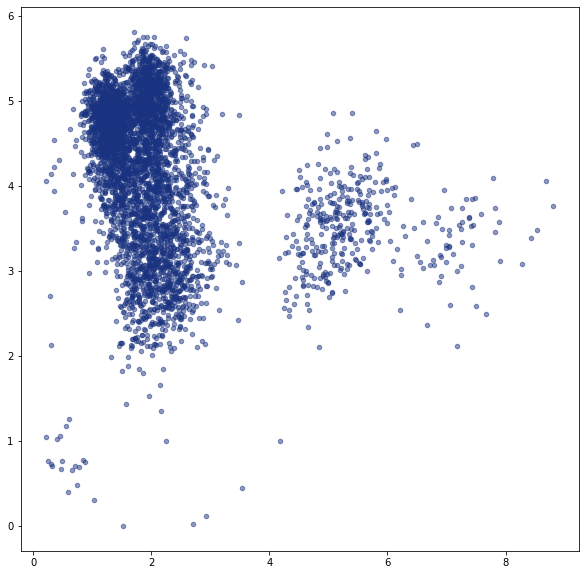

In [ ]:
axis1 = encoded_trajectories[0][:,0]
axis2 = encoded_trajectories[0][:,1]
plt.subplots(figsize=(10, 10))
plt.scatter(x=axis1, y=axis2, s=20, color=(0.1, 0.2, 0.5, 0.5))

# Clustering on the latent space using DBSCAN

In [ ]:
# The complete dataset is needed to plot real trajectories later
complete_dataset = landing_zurich_2019.query("runway == '14' and initial_flow != 'N/A'").query("initial_flow == '162-216'").unwrap("track").eval()

In [ ]:
# Function to cluster the trajectories in latent space then save a picture of real and latent space clustered
def cluster(model, model_name, eps=0.2, show_fig="false"):
  encoded_trajectories = []
  model.eval()
  model.encoder.eval()
  with torch.no_grad():
      for flight_id, trajectory in dataloader_train:
          trajectory = trajectory.reshape(-1, 4*64)
          trajectory = torch.Tensor(sklearn.preprocessing.minmax_scale(trajectory, feature_range=(0, 1)))
          encoded = model.encoder(trajectory)
          encoded_trajectories.append(encoded)
  X = encoded_trajectories[0]
  db = DBSCAN(eps=eps, min_samples=2).fit(X)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  
  # Linking each flight id with its cluster
  fid_cluster = list(zip(flight_ids, labels))
  fid_cluster = pd.DataFrame(fid_cluster,
                columns =['flight_id', 'cluster'])

  clustered_df = complete_dataset.data.set_index("flight_id").join(fid_cluster.set_index("flight_id"), how='left')
  # Black removed and is used for noise instead.
  unique_labels = set(labels) 
  colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

  # Getting the number of clusters and noise points
  n_clusters_ = len(unique_labels) # Number of clusters in dataset, ignoring noise if present.
  n_noise_ = list(labels).count(-1)
  print(f"Found {n_clusters_}") 

  # In case DBSCAN found mutiple clusters, we plot the corresponding trajectories
  if n_clusters_ <= 1 :
    return

  # Plotting trajectories 1by1 in real space and clusters in latent spece side by side
  nrow = n_clusters_//2+1; ncol = n_clusters_//2;

  grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.3)

  fig = plt.figure(figsize=(20,20))
  sfigs = fig.subfigures(1, 2)

  axs = sfigs[0].subplots(nrows=nrow, ncols=ncol)

  if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

  for k, col, ax in zip(unique_labels, colors, axs.reshape(-1)):
      # Setting Alpha
      col = list(col)     
      col[3] = 1

      if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

      # Plot the cluster 
      cluster = clustered_df[clustered_df["cluster"] == k]
      ax.scatter(x=cluster["longitude"], y=cluster["latitude"], s=0.5, color=col)

  # Plotting latent space
  axs1 = sfigs[1].subplots(nrows=1, ncols=1)
  for k, col in zip(unique_labels, colors):

      # Setting alpha
      col = list(col)     
      col[3] = 0.9

      if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

      class_member_mask = labels == k
      xy = X[class_member_mask & core_samples_mask]
      axs1.scatter(
          x=xy[:, 0],
          y=xy[:, 1],
          s=20,
          color=tuple(col),
      )
      
      xy = X[class_member_mask & ~core_samples_mask]
      axs1.plot(
          xy[:,0],
          xy[:, 1],
          "o",
          markerfacecolor=tuple(col),
          markeredgecolor="k",
          markersize=6,
      )
      axs1.set_aspect('equal', adjustable='box')
  if show_fig : 
    plt.show()
  fig.savefig("pictures/" + model_name + ".png")

Found 1
Found 2


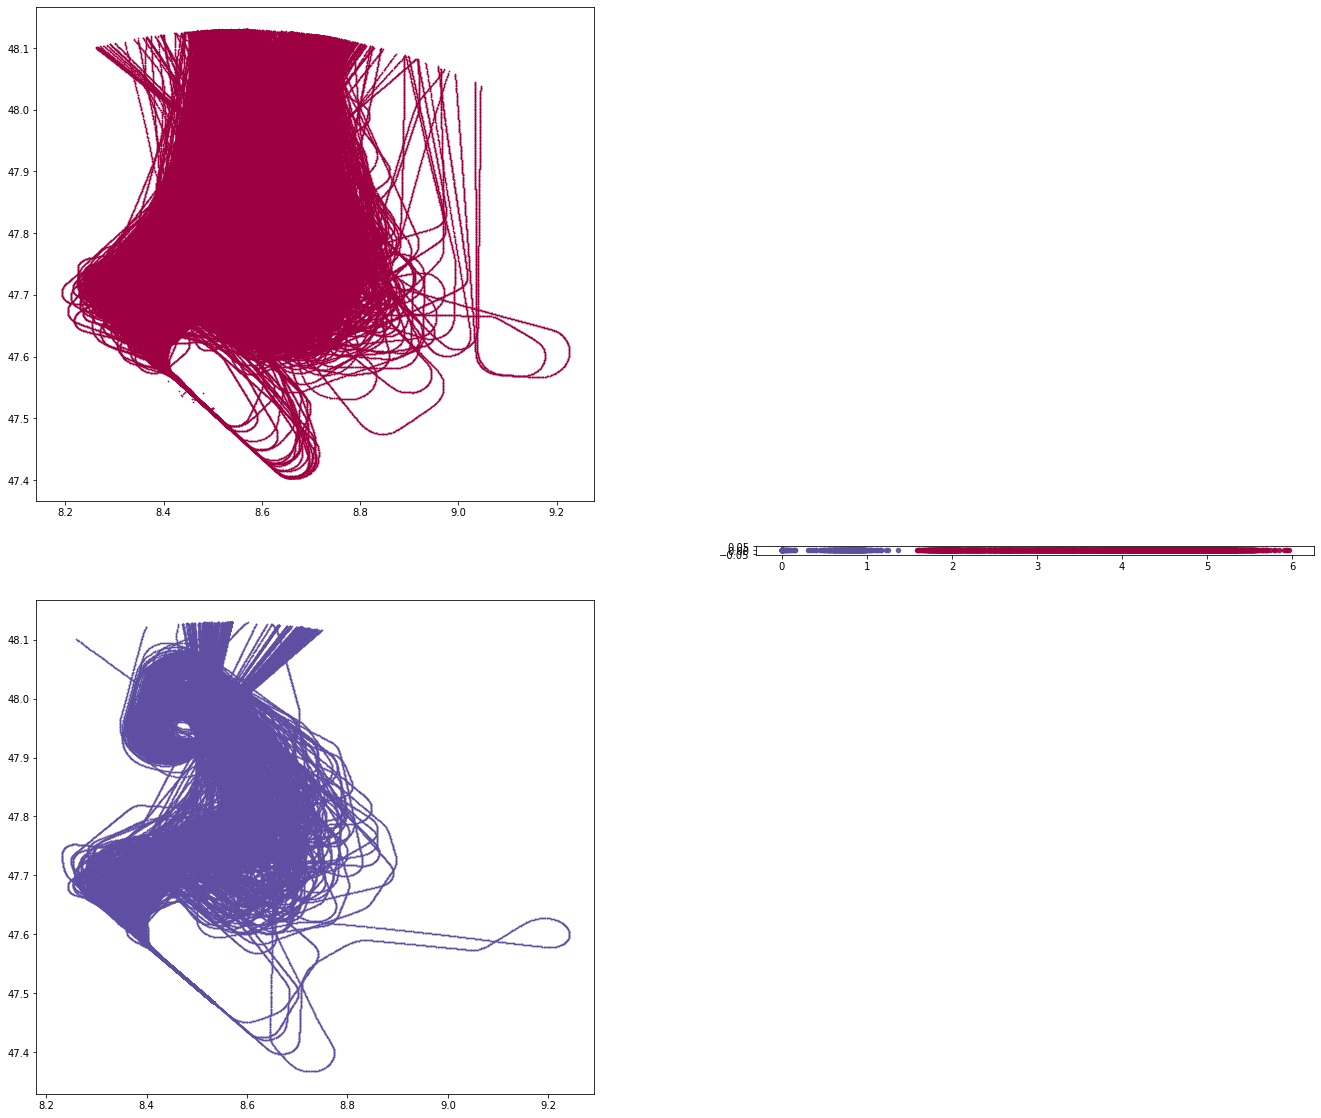

Found 5


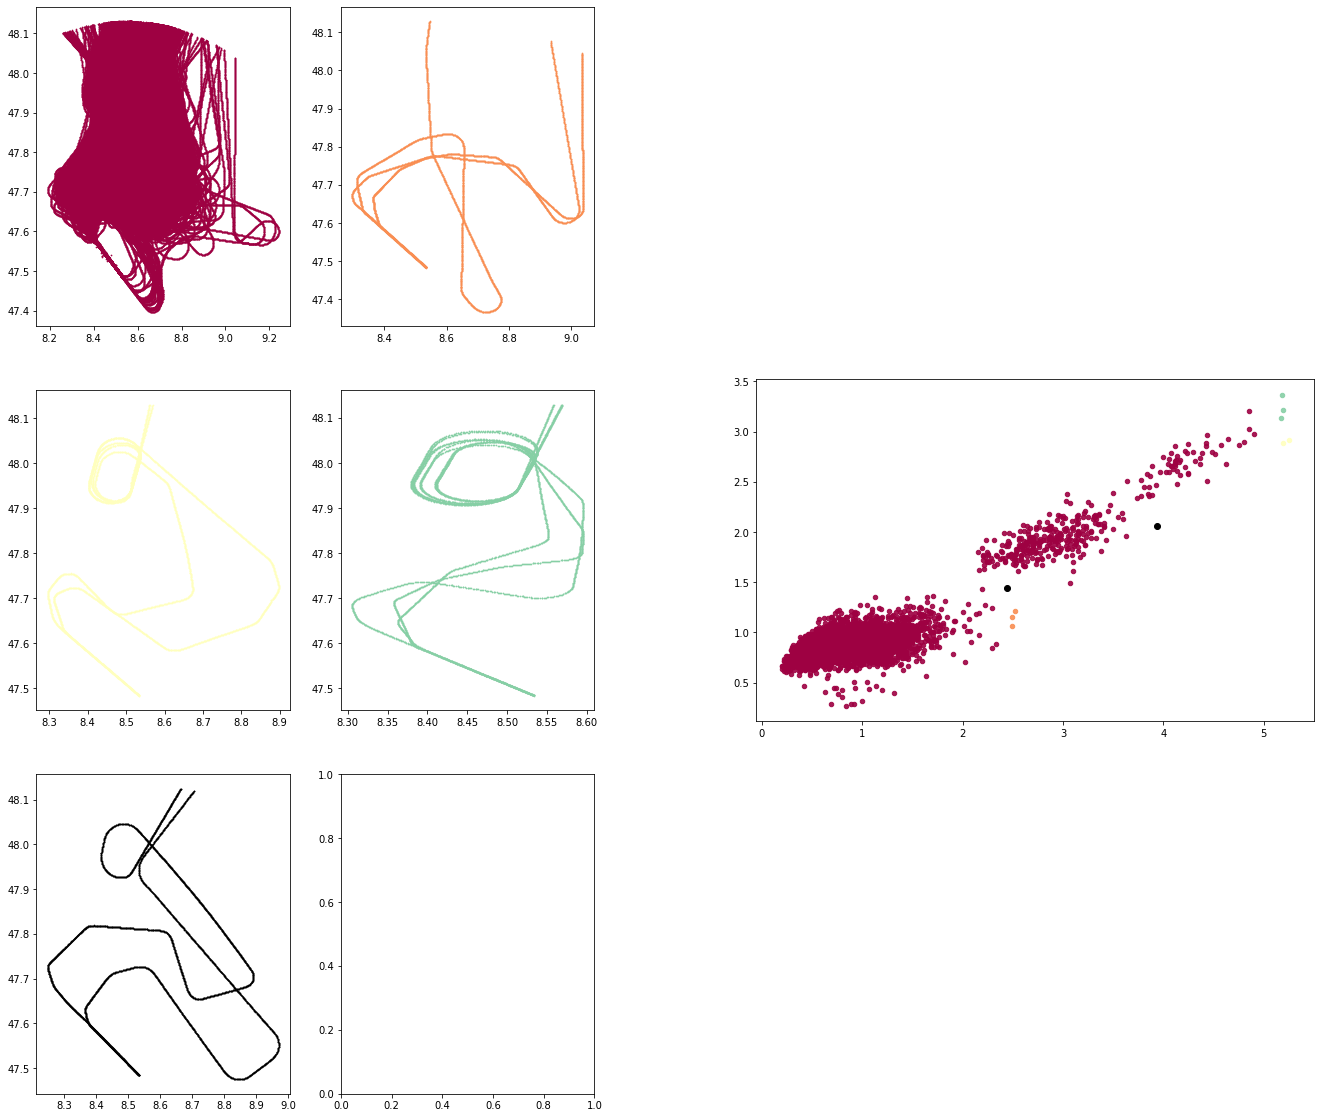

Found 2


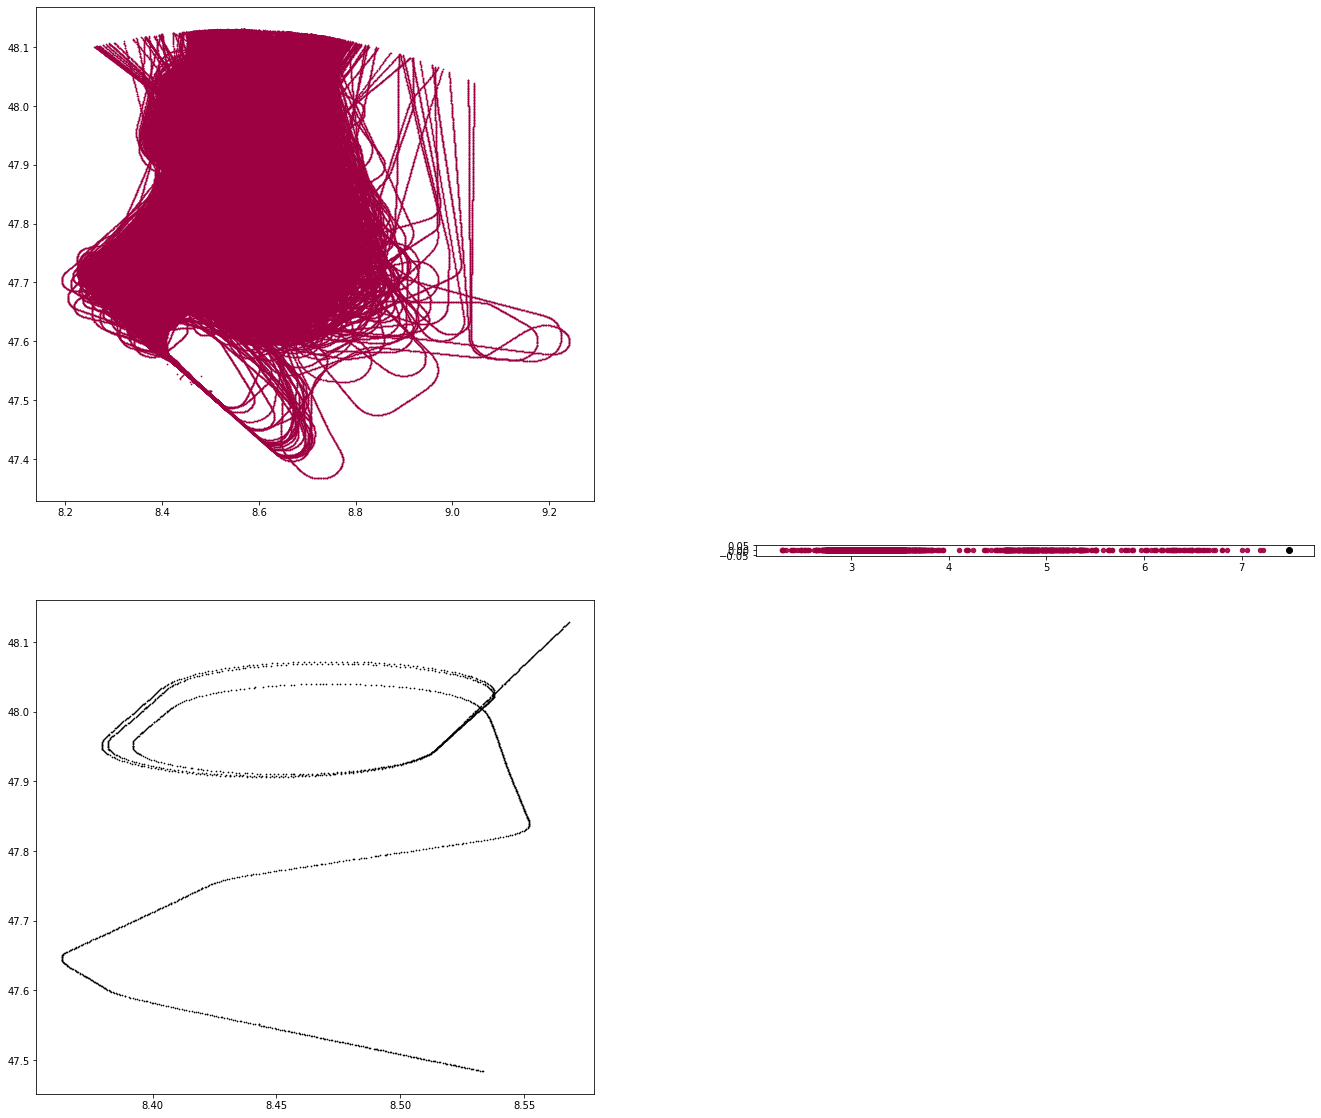

Found 1
Found 2


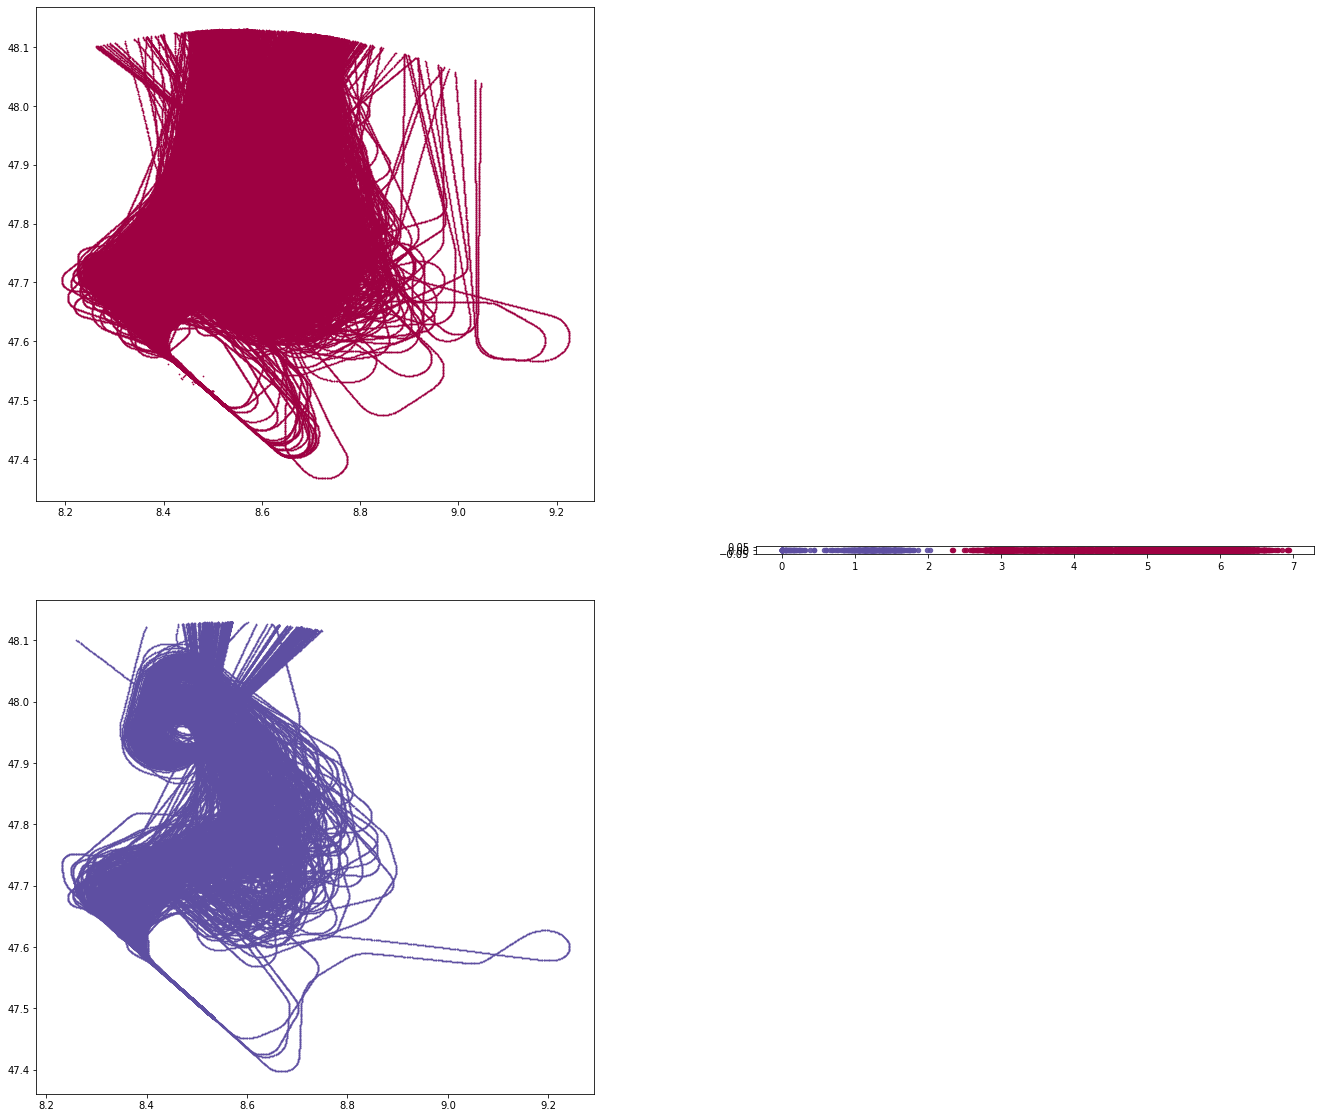

Found 7


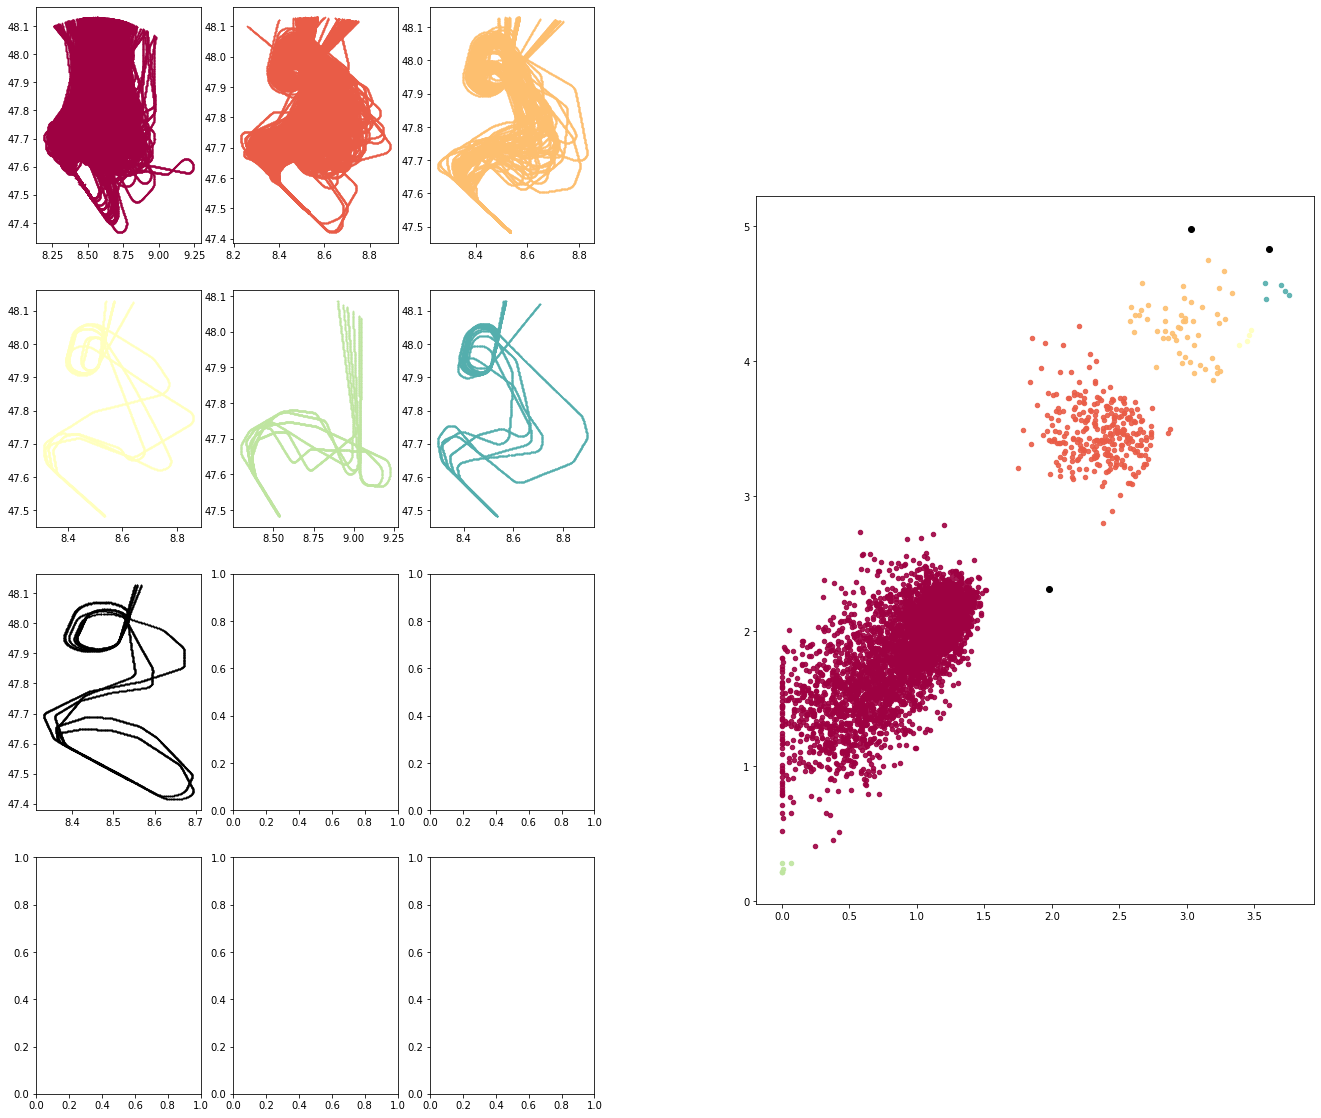

Found 1
Found 4


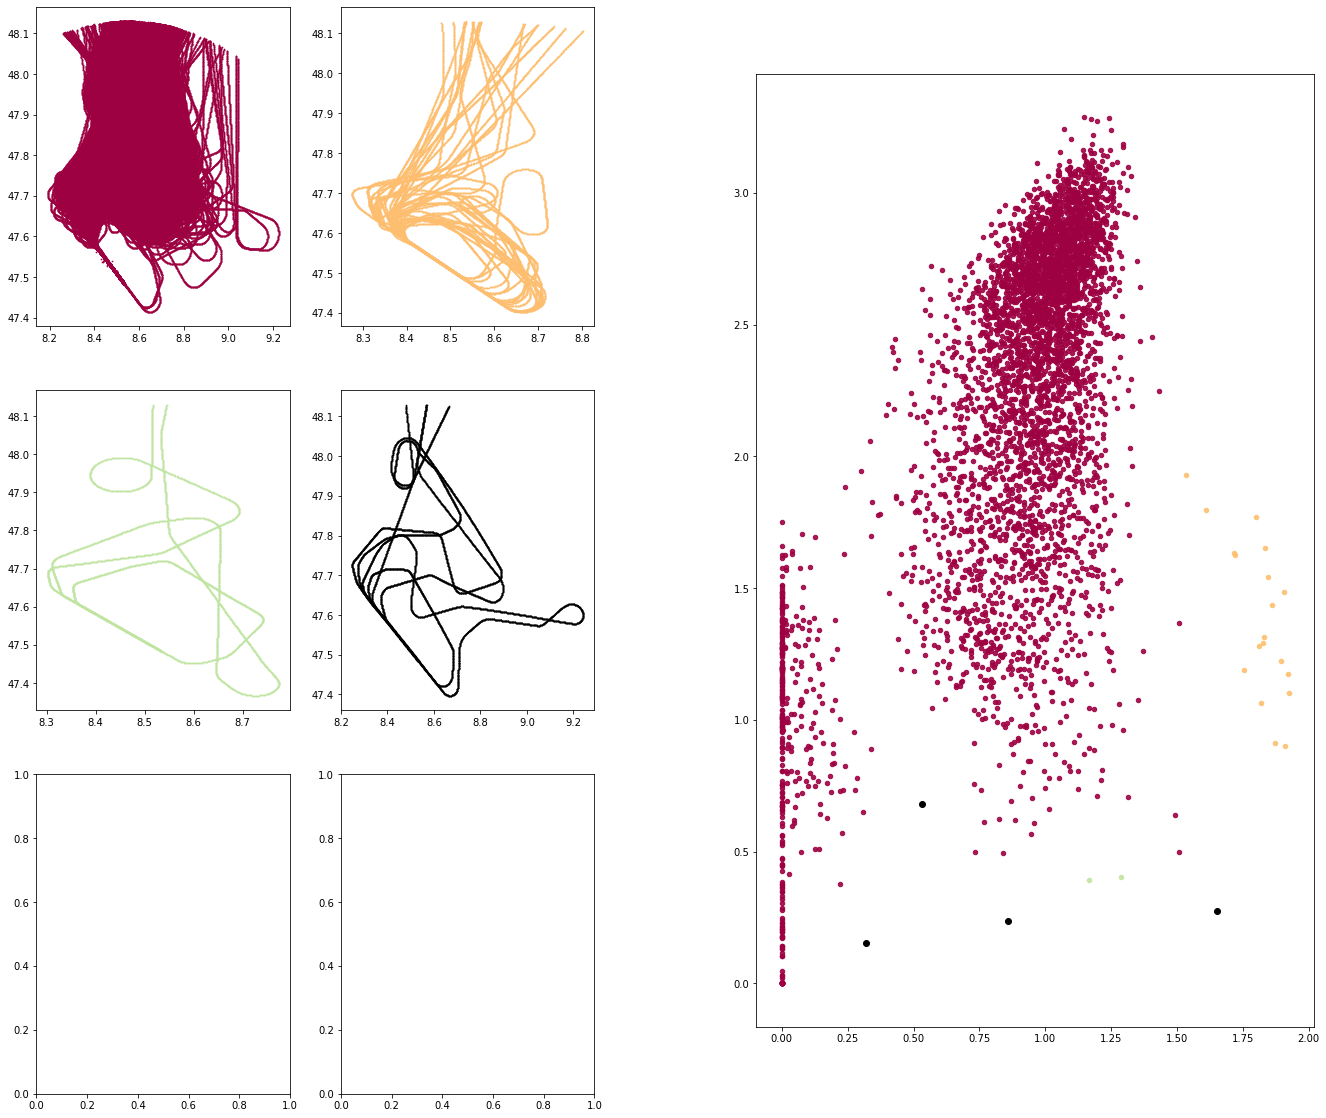

Found 1
Found 1
Found 5


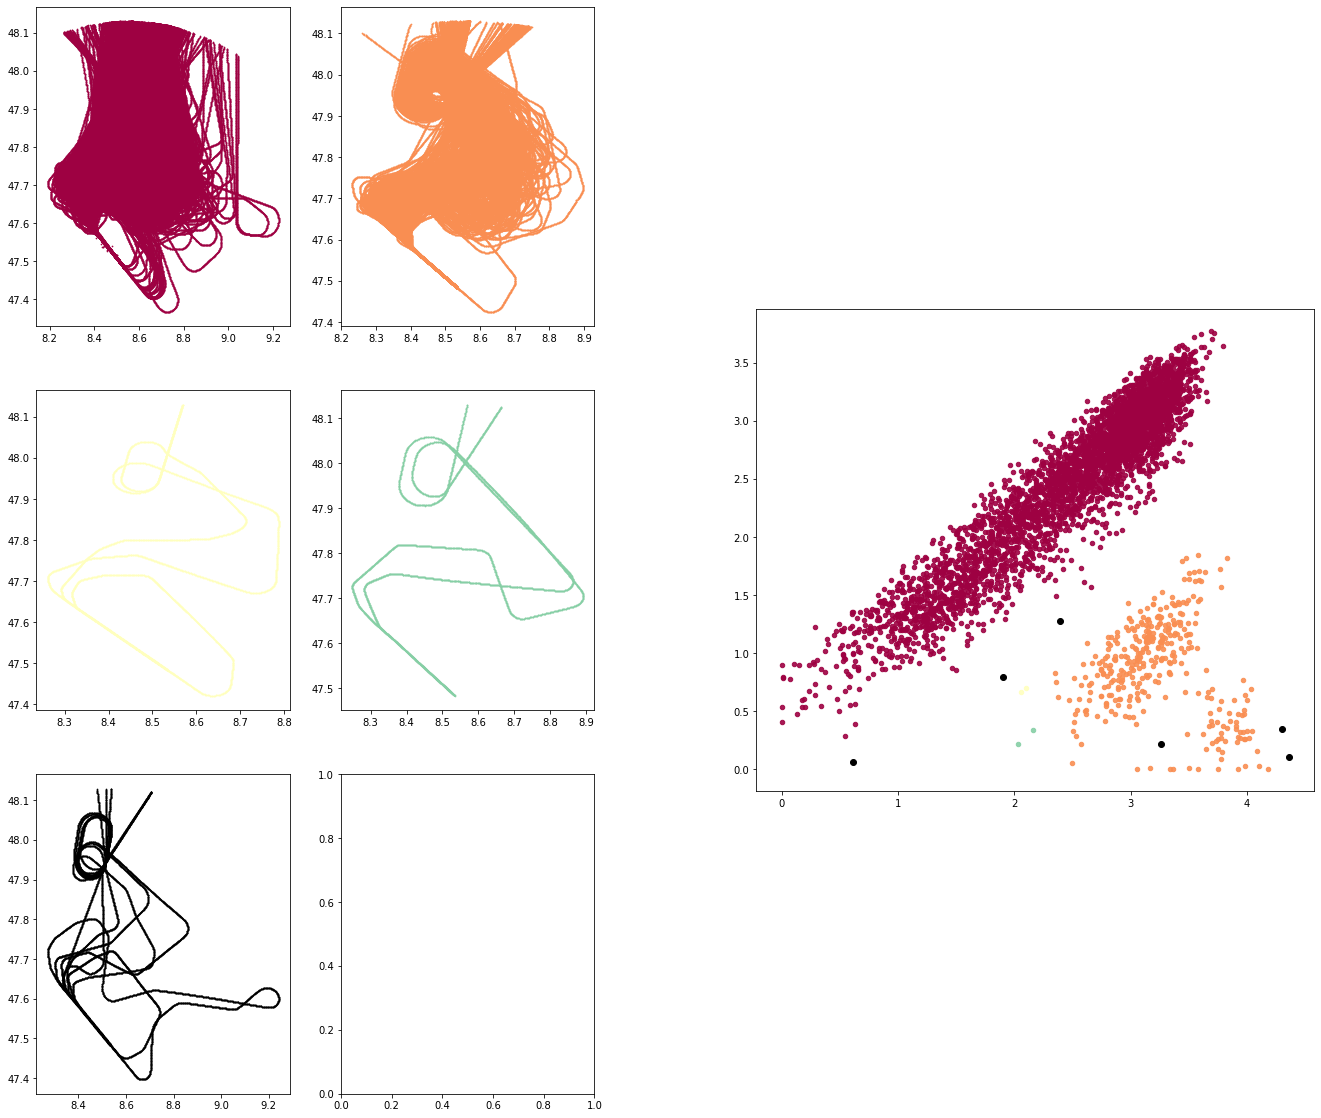

Found 10


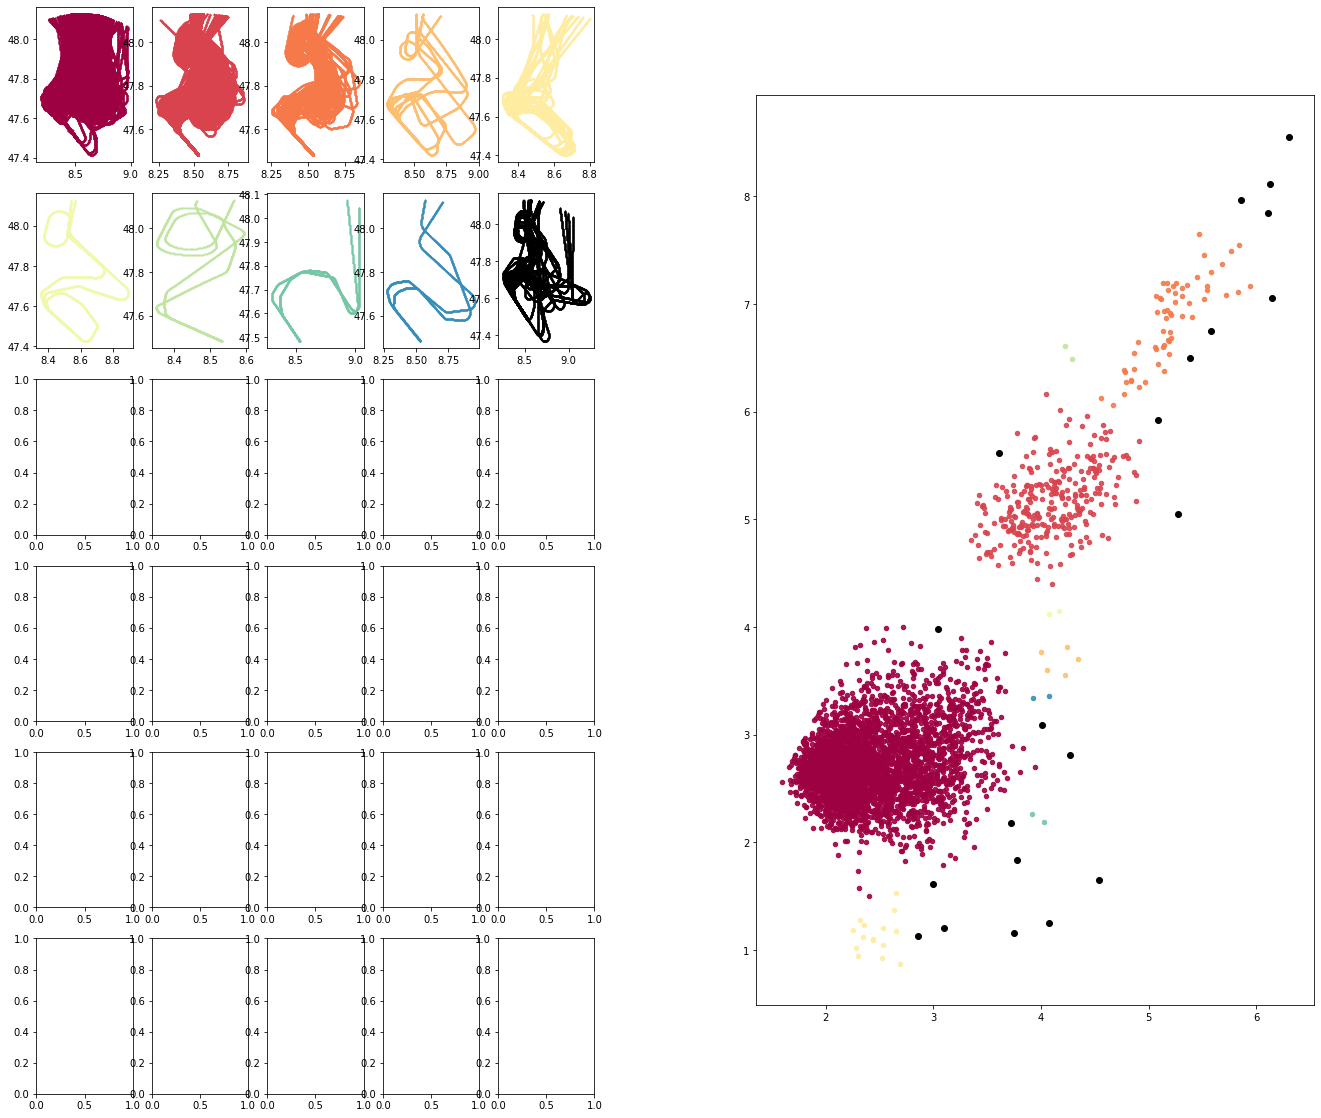

Found 5


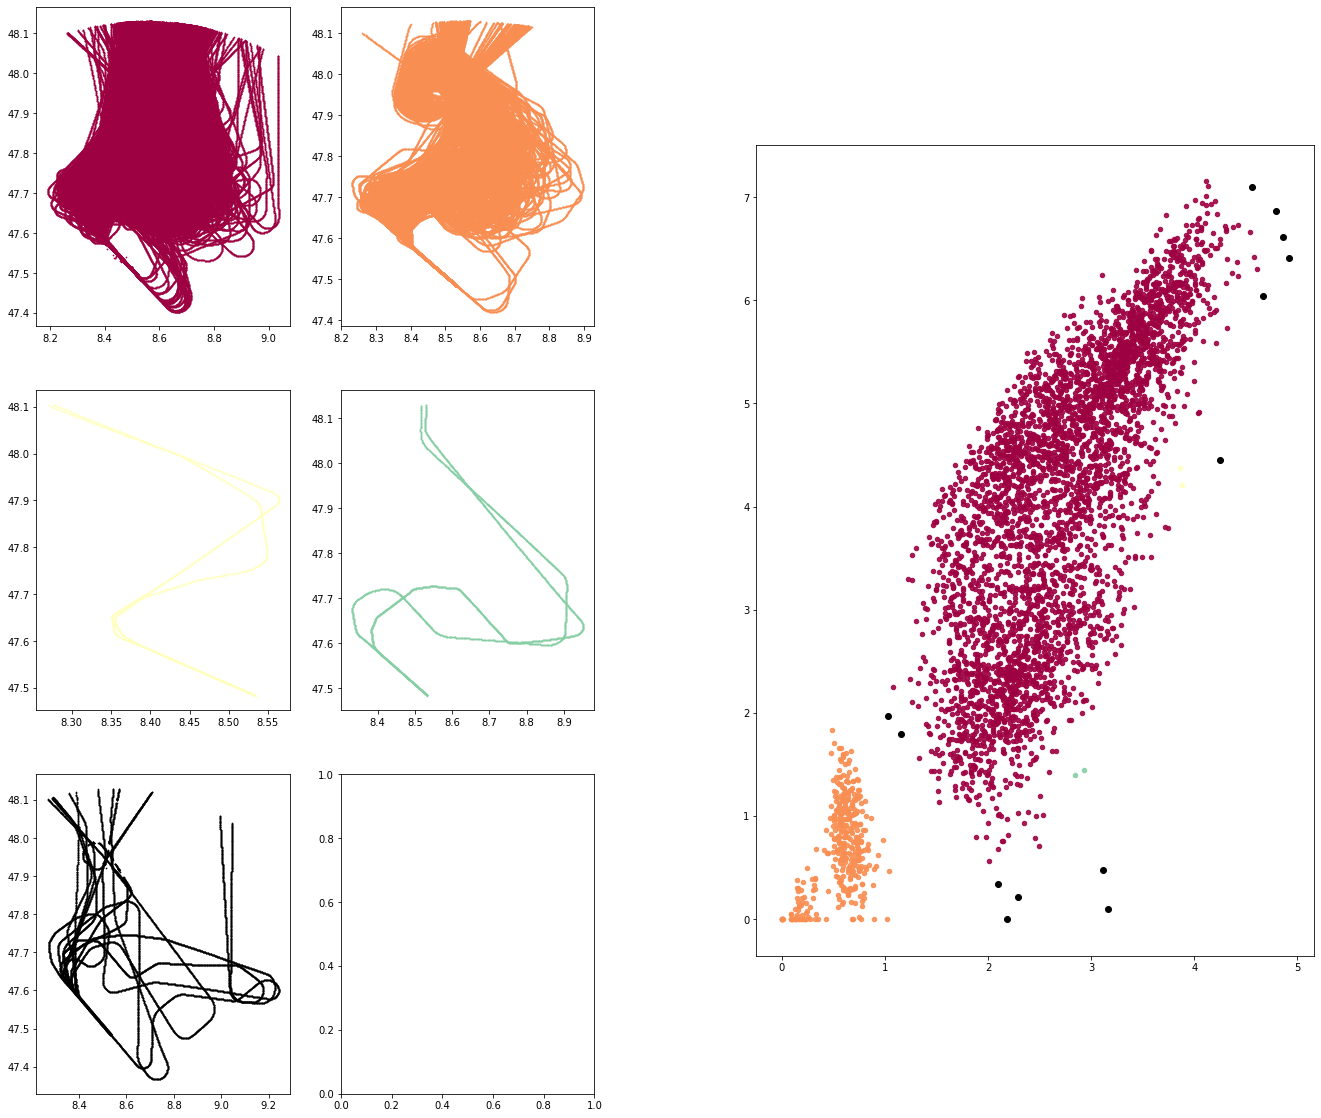

Found 2


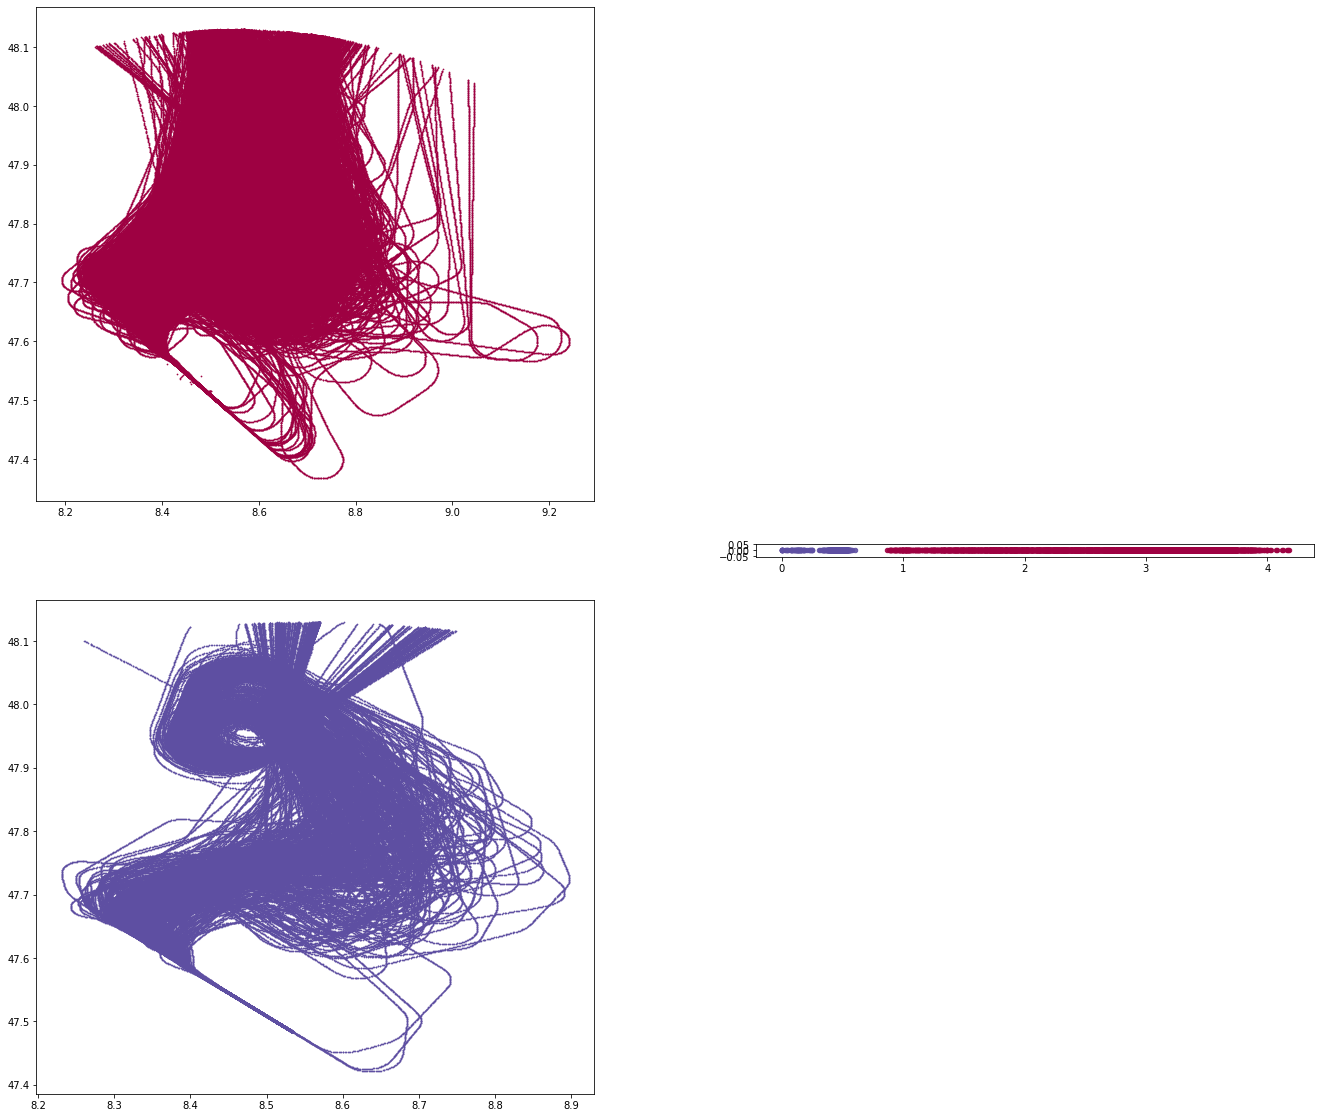

Found 1
Found 1
Found 1
Found 1
Found 5


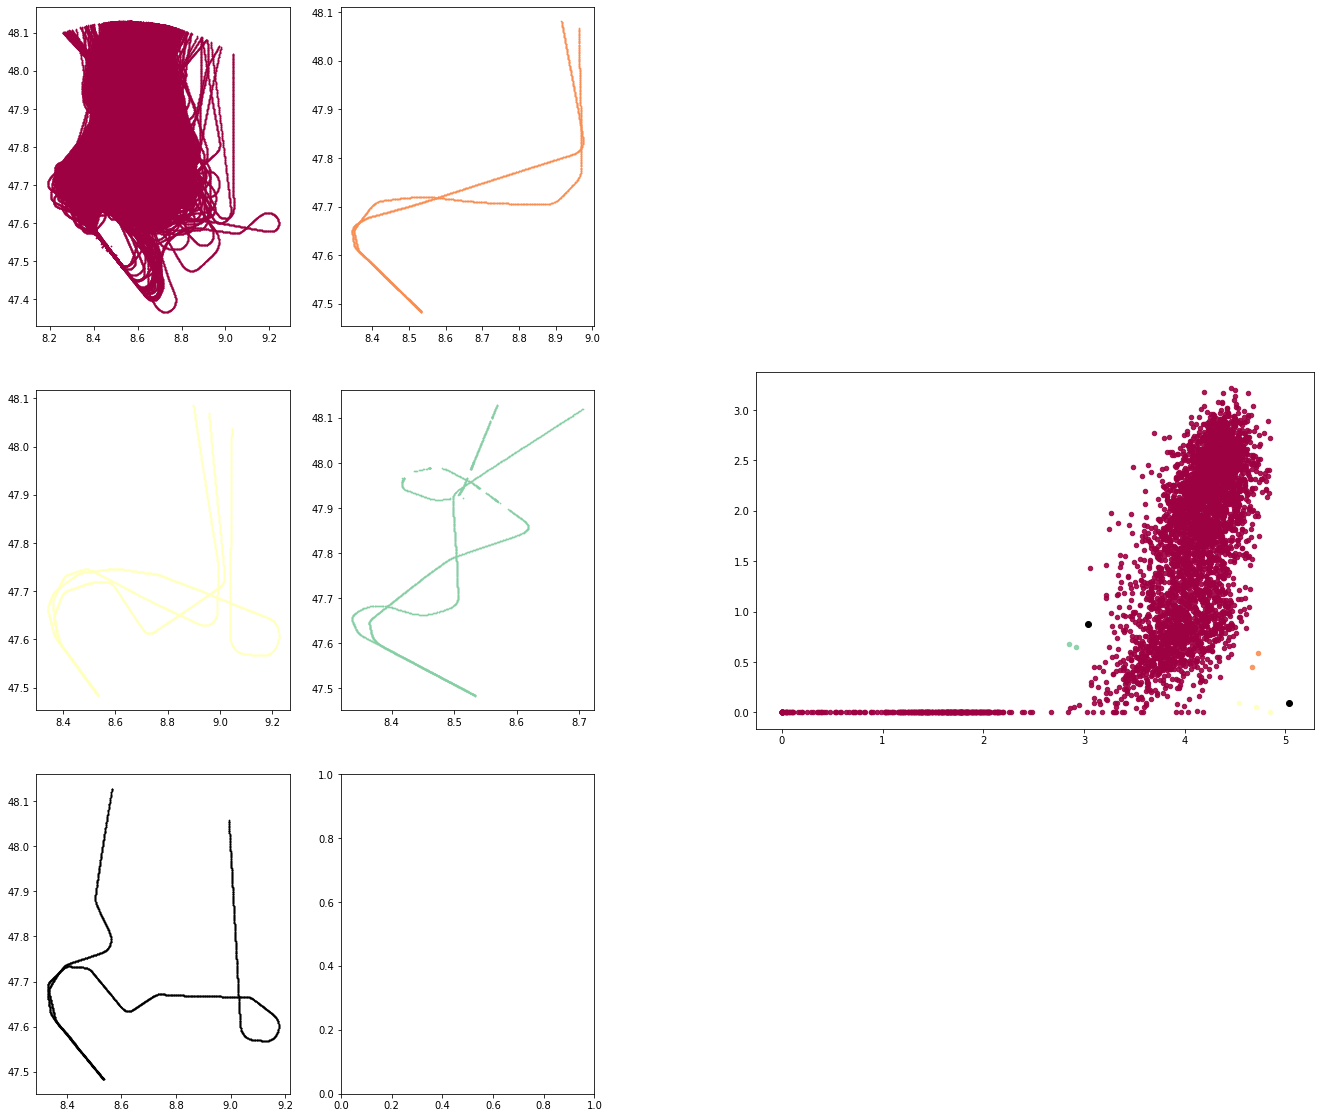

In [ ]:
# Clustering based on all trained models saved
for root, dirs, files in os.walk("./data", topdown = False): # Itereate over all models

   for name in files:
      model_name, _ = os.path.splitext(name)
      model = load_model(name=model_name)
      cluster(model, model_name)


# Detecting anomalies using reconstruction error




In [ ]:
recon_trajectories = []
recon_errors = []

best_model.eval()
mse = torch.nn.MSELoss()

with torch.no_grad():
    for trajectory in dataloader_score:
        # Preparing trajectory
        trajectory = trajectory[0].reshape(4*64)
        trajectory = torch.Tensor(sklearn.preprocessing.minmax_scale(trajectory.double(), feature_range=(0, 1)))
        # Reconstructing
        reconstructed = best_model(trajectory) 
        # Calculating errors
        recon_trajectories.append(reconstructed)
        recon_errors.append(mse(trajectory, reconstructed).item())
min(recon_errors), max(recon_errors)

(0.11698762327432632, 0.17719705402851105)

In [ ]:
# Getting sorted indices first
sorted_indexes = np.argsort(recon_errors)
# Building a list of orderer trajectories by error 
ordered_traj = [dataset[i] for i in sorted_indexes]

In [ ]:
# Adding errors to trajectories df 
err_df = data_grouped.copy()
err_df["errors"] = recon_errors
err_df = err_df.sort_values(by='errors', ascending=False)
err_df['anomaly_rank'] = range(1, len(err_df) + 1)
err_df

,flight_id,trajectories,errors,anomaly_rank
3522,SWR5055_10927,"[[175.3536645088041, 8.491375262920673, 48.127...",0.177197,1
1087,EWG7NM_1334,"[[183.39971415912322, 8.529647827148438, 48.12...",0.176811,2
495,EFD2D_2344,"[[216.1702553320909, 8.723831176757812, 48.118...",0.176271,3
2319,SWR116W_16545,"[[193.4258092497147, 8.731102576622595, 48.117...",0.175646,4
2337,SWR116W_17520,"[[208.43392410149033, 8.660659790039062, 48.12...",0.175454,5
...,...,...,...,...
1048,EWG764_1910,"[[173.7655199044588, 8.479179382324219, 48.126...",0.120097,4433
187,DIGRO_2346,"[[182.9273479917409, 8.552293043870193, 48.127...",0.119446,4434
1140,EWG9776_1540,"[[190.7446413266131, 8.569267272949219, 48.129...",0.117700,4435
333,DLH6MH_1827,"[[188.8282646539731, 8.536102294921875, 48.130...",0.117307,4436


In [ ]:
# Get the complete dataset without the resampling
complete_dataset = landing_zurich_2019.query("runway == '14' and initial_flow != 'N/A'").query("initial_flow == '162-216'").unwrap("track").eval()

In [ ]:
complete_data = complete_dataset.data.copy()
complete_data = complete_data.set_index("flight_id").join(err_df.set_index("flight_id"), how='left')

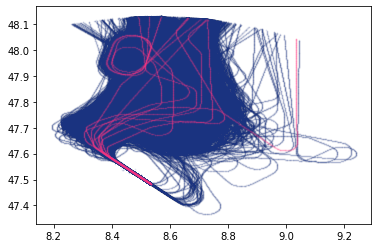

In [ ]:
number_anomalies = 10
normal_data = complete_data[complete_data["anomaly_rank"] > number_anomalies]
anomalous_data = complete_data[complete_data["anomaly_rank"] <= number_anomalies]
plt.scatter(x=normal_data["longitude"], y=normal_data["latitude"], s=0.5, color=(0.1, 0.2, 0.5,0.1))
plt.scatter(x=anomalous_data["longitude"], y=anomalous_data["latitude"], s=0.5, color=(1, 0.2, 0.5,0.1))